$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [44]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [45]:
import cs3600.plot as plot
import cs3600.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs3600.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\x3yusk\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\x3yusk\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\x3yusk\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [46]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


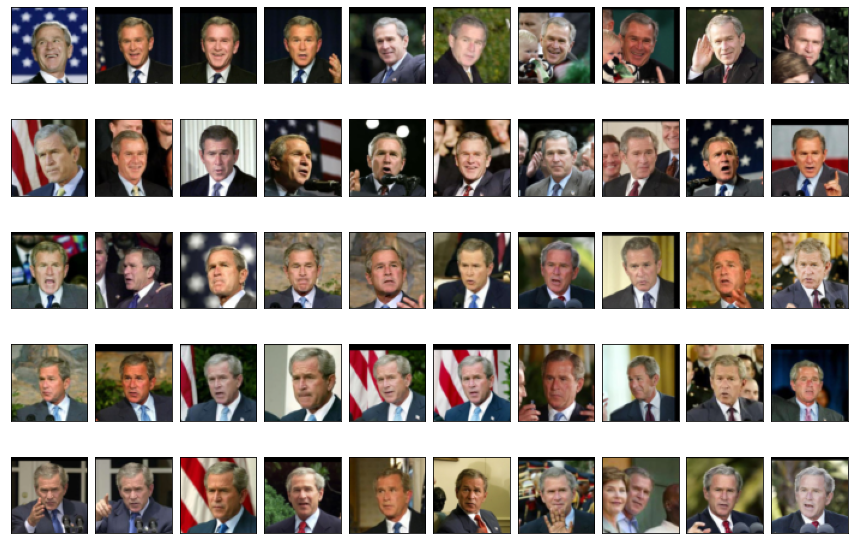

In [47]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [48]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [49]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [50]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(4, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [51]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [52]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

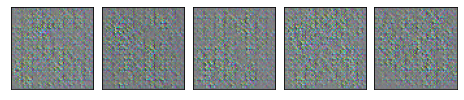

In [53]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [54]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, 0, hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, 1)

# Training
checkpoint_file = 'checkpoints/gan6'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 128, 'z_dim': 100, 'data_label': 0, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.9999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.9999)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]
Discriminator loss: 0.29662831127643585
Generator loss:     6.471881103515625
Saved checkpoint.


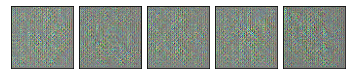

--- EPOCH 2/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]
Discriminator loss: -0.08032883908599615
Generator loss:     7.379827880859375
Saved checkpoint.
--- EPOCH 3/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]
Discriminator loss: 0.0721339151263237
Generator loss:     7.108449077606201
Saved checkpoint.
--- EPOCH 4/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.83it/s]
Discriminator loss: -0.08562638089060784
Generator loss:     6.207993984222412
Saved checkpoint.
--- EPOCH 5/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]
Discriminator loss: -0.05552229285240173
Generator loss:     7.3983818054199215
Saved checkpoint.
--- EPOCH 6/2000 ---
100%|███████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: 0.08235001787543297
Generator loss:     10.256057167053223
Saved checkpoint.
--- EPOCH 37/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: -0.04500313103199005
Generator loss:     11.756673622131348
Saved checkpoint.
--- EPOCH 38/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]
Discriminator loss: 0.010115250945091248
Generator loss:     11.173075675964355
Saved checkpoint.
--- EPOCH 39/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]
Discriminator loss: -0.052205358445644376
Generator loss:     11.434254264831543
Saved checkpoint.
--- EPOCH 40/2000 ---
100%|███████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]
Discriminator loss: 0.0018191449344158173
Generator loss:     7.504322624206543
Saved checkpoint.
--- EPOCH 71/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.79it/s]
Discriminator loss: -0.04885824471712112
Generator loss:     6.619090461730957
Saved checkpoint.
--- EPOCH 72/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.82it/s]
Discriminator loss: -0.15241086557507516
Generator loss:     6.899625015258789
Saved checkpoint.
--- EPOCH 73/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: 0.1320122629404068
Generator loss:     6.832294654846192
Saved checkpoint.
--- EPOCH 74/2000 ---
100%|████████████████████████████████████████

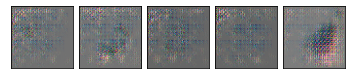

--- EPOCH 102/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]
Discriminator loss: -0.09897394329309464
Generator loss:     8.946266841888427
Saved checkpoint.
--- EPOCH 103/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: 0.0014706388115882873
Generator loss:     9.015991592407227
Saved checkpoint.
--- EPOCH 104/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: -0.08629101142287254
Generator loss:     8.814143562316895
Saved checkpoint.
--- EPOCH 105/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]
Discriminator loss: -0.20646982640028
Generator loss:     9.438323783874512
Saved checkpoint.
--- EPOCH 106/2000 ---
100%|██████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.77it/s]
Discriminator loss: -0.14317681416869163
Generator loss:     12.536567306518554
Saved checkpoint.
--- EPOCH 137/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]
Discriminator loss: -0.2683700203895569
Generator loss:     16.47415657043457
Saved checkpoint.
--- EPOCH 138/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: -0.11338857114315033
Generator loss:     18.09679412841797
Saved checkpoint.
--- EPOCH 139/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]
Discriminator loss: 0.40814426690340044
Generator loss:     16.075874900817873
Saved checkpoint.
--- EPOCH 140/2000 ---
100%|███████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]
Discriminator loss: 0.048222902417182925
Generator loss:     6.181056308746338
Saved checkpoint.
--- EPOCH 171/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]
Discriminator loss: 0.03640802055597305
Generator loss:     6.041182899475098
Saved checkpoint.
--- EPOCH 172/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]
Discriminator loss: 0.15612456053495408
Generator loss:     5.5320329666137695
Saved checkpoint.
--- EPOCH 173/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]
Discriminator loss: 0.11572771295905113
Generator loss:     5.716854000091553
Saved checkpoint.
--- EPOCH 174/2000 ---
100%|█████████████████████████████████████

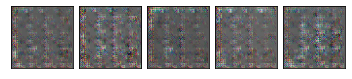

--- EPOCH 202/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]
Discriminator loss: 0.002824215590953827
Generator loss:     16.839091873168947
Saved checkpoint.
--- EPOCH 203/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]
Discriminator loss: 0.22358540296554566
Generator loss:     17.956615447998047
Saved checkpoint.
--- EPOCH 204/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]
Discriminator loss: 0.07864069044589997
Generator loss:     20.531475830078126
Saved checkpoint.
--- EPOCH 205/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: 0.3720190703868866
Generator loss:     16.4466215133667
Saved checkpoint.
--- EPOCH 206/2000 ---
100%|██████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: -0.038206669688224795
Generator loss:     15.014907073974609
Saved checkpoint.
--- EPOCH 237/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]
Discriminator loss: 0.06441682428121567
Generator loss:     13.303468132019043
Saved checkpoint.
--- EPOCH 238/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: -0.22728307992219926
Generator loss:     12.950088500976562
Saved checkpoint.
--- EPOCH 239/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]
Discriminator loss: -0.12407563030719757
Generator loss:     16.126979255676268
Saved checkpoint.
--- EPOCH 240/2000 ---
100%|███████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]
Discriminator loss: -0.07041742205619812
Generator loss:     8.703536415100098
Saved checkpoint.
--- EPOCH 271/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: 0.030872415006160735
Generator loss:     7.892881298065186
Saved checkpoint.
--- EPOCH 272/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]
Discriminator loss: -0.11331461668014527
Generator loss:     10.41838493347168
Saved checkpoint.
--- EPOCH 273/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]
Discriminator loss: 0.014184583723545075
Generator loss:     17.13352451324463
Saved checkpoint.
--- EPOCH 274/2000 ---
100%|███████████████████████████████████

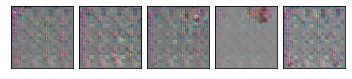

--- EPOCH 302/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]
Discriminator loss: 0.005302855372428894
Generator loss:     7.966524982452393
Saved checkpoint.
--- EPOCH 303/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]
Discriminator loss: -0.23299506977200507
Generator loss:     6.688313961029053
Saved checkpoint.
--- EPOCH 304/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]
Discriminator loss: -0.0021969497203826903
Generator loss:     6.79374361038208
Saved checkpoint.
--- EPOCH 305/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.10it/s]
Discriminator loss: -1.1271238327026367e-05
Generator loss:     6.9043985366821286
Saved checkpoint.
--- EPOCH 306/2000 ---
100%|███████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]
Discriminator loss: -0.04106602743268013
Generator loss:     8.056538391113282
Saved checkpoint.
--- EPOCH 337/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.07it/s]
Discriminator loss: 0.43706603050231935
Generator loss:     5.824570369720459
Saved checkpoint.
--- EPOCH 338/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.10it/s]
Discriminator loss: -0.049923868477344514
Generator loss:     5.188114261627197
Saved checkpoint.
--- EPOCH 339/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.07it/s]
Discriminator loss: 0.15825071930885315
Generator loss:     6.7872169494628904
Saved checkpoint.
--- EPOCH 340/2000 ---
100%|███████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]
Discriminator loss: 0.12906091660261154
Generator loss:     5.697725009918213
Saved checkpoint.
--- EPOCH 371/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  5.00it/s]
Discriminator loss: 0.008880165964365005
Generator loss:     6.329427051544189
Saved checkpoint.
--- EPOCH 372/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.86it/s]
Discriminator loss: 0.07929659858345986
Generator loss:     7.0951591491699215
Saved checkpoint.
--- EPOCH 373/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]
Discriminator loss: -0.11471672058105468
Generator loss:     6.490151214599609
Saved checkpoint.
--- EPOCH 374/2000 ---
100%|████████████████████████████████████

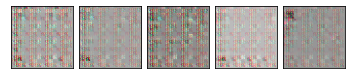

--- EPOCH 402/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]
Discriminator loss: -0.6040000796318055
Generator loss:     15.219242286682128
Saved checkpoint.
--- EPOCH 403/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.70it/s]
Discriminator loss: 0.20378888100385667
Generator loss:     15.994320106506347
Saved checkpoint.
--- EPOCH 404/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.84it/s]
Discriminator loss: -0.5253130376338959
Generator loss:     19.792922973632812
Saved checkpoint.
--- EPOCH 405/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: 0.08908767253160477
Generator loss:     17.563785552978516
Saved checkpoint.
--- EPOCH 406/2000 ---
100%|████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]
Discriminator loss: 0.16153629422187804
Generator loss:     19.872007369995117
Saved checkpoint.
--- EPOCH 437/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: 0.21892001628875732
Generator loss:     19.618349075317383
Saved checkpoint.
--- EPOCH 438/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.09it/s]
Discriminator loss: 0.06858392357826233
Generator loss:     17.38743438720703
Saved checkpoint.
--- EPOCH 439/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]
Discriminator loss: 0.11507266163825988
Generator loss:     14.669096374511719
Saved checkpoint.
--- EPOCH 440/2000 ---
100%|████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]
Discriminator loss: 0.2604001834988594
Generator loss:     10.408907890319824
Saved checkpoint.
--- EPOCH 471/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: 0.1671383112668991
Generator loss:     10.669451141357422
Saved checkpoint.
--- EPOCH 472/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]
Discriminator loss: 0.027495142817497254
Generator loss:     11.32958812713623
Saved checkpoint.
--- EPOCH 473/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: -0.0015651404857635498
Generator loss:     9.548082733154297
Saved checkpoint.
--- EPOCH 474/2000 ---
100%|███████████████████████████████████

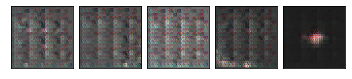

--- EPOCH 502/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]
Discriminator loss: -0.01438399702310562
Generator loss:     8.368979835510254
Saved checkpoint.
--- EPOCH 503/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]
Discriminator loss: -0.12359563186764717
Generator loss:     7.856189155578614
Saved checkpoint.
--- EPOCH 504/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: -0.0552626833319664
Generator loss:     7.64030122756958
Saved checkpoint.
--- EPOCH 505/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: 0.11535473167896271
Generator loss:     8.272080612182616
Saved checkpoint.
--- EPOCH 506/2000 ---
100%|███████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]
Discriminator loss: 0.1259776994585991
Generator loss:     8.950215148925782
Saved checkpoint.
--- EPOCH 537/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]
Discriminator loss: -0.015036533772945403
Generator loss:     8.304058170318603
Saved checkpoint.
--- EPOCH 538/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]
Discriminator loss: -0.1293878123164177
Generator loss:     8.335936737060546
Saved checkpoint.
--- EPOCH 539/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.06it/s]
Discriminator loss: 0.052212537825107576
Generator loss:     8.989747238159179
Saved checkpoint.
--- EPOCH 540/2000 ---
100%|█████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]
Discriminator loss: -0.28355280458927157
Generator loss:     9.339652824401856
Saved checkpoint.
--- EPOCH 571/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.86it/s]
Discriminator loss: -0.042414617538452146
Generator loss:     8.040776348114013
Saved checkpoint.
--- EPOCH 572/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.82it/s]
Discriminator loss: -0.11570166721940041
Generator loss:     9.264144706726075
Saved checkpoint.
--- EPOCH 573/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]
Discriminator loss: 0.2554236248135567
Generator loss:     8.98446102142334
Saved checkpoint.
--- EPOCH 574/2000 ---
100%|█████████████████████████████████████

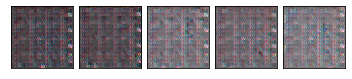

--- EPOCH 602/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]
Discriminator loss: -0.3403162270784378
Generator loss:     10.956415748596191
Saved checkpoint.
--- EPOCH 603/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: -0.20066664218902588
Generator loss:     14.556525611877442
Saved checkpoint.
--- EPOCH 604/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.72it/s]
Discriminator loss: -0.053433725237846376
Generator loss:     13.126052474975586
Saved checkpoint.
--- EPOCH 605/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: -0.34785933792591095
Generator loss:     14.353412437438966
Saved checkpoint.
--- EPOCH 606/2000 ---
100%|████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]
Discriminator loss: 0.17939174249768258
Generator loss:     11.061147689819336
Saved checkpoint.
--- EPOCH 637/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.82it/s]
Discriminator loss: -0.06229716837406159
Generator loss:     10.500511169433594
Saved checkpoint.
--- EPOCH 638/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.72it/s]
Discriminator loss: 0.010674776136875152
Generator loss:     12.318708419799805
Saved checkpoint.
--- EPOCH 639/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]
Discriminator loss: -0.10068404525518418
Generator loss:     11.012556838989259
Saved checkpoint.
--- EPOCH 640/2000 ---
100%|████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: 0.006283387541770935
Generator loss:     15.341534233093261
Saved checkpoint.
--- EPOCH 671/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]
Discriminator loss: 0.027817952632904052
Generator loss:     12.944112968444824
Saved checkpoint.
--- EPOCH 672/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]
Discriminator loss: -0.12325332909822465
Generator loss:     15.548031997680663
Saved checkpoint.
--- EPOCH 673/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.77it/s]
Discriminator loss: 0.1545139491558075
Generator loss:     12.216568565368652
Saved checkpoint.
--- EPOCH 674/2000 ---
100%|█████████████████████████████████

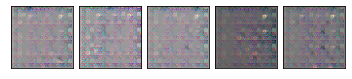

--- EPOCH 702/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.00it/s]
Discriminator loss: 0.14183045476675032
Generator loss:     13.425634765625
Saved checkpoint.
--- EPOCH 703/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]
Discriminator loss: -0.30610036551952363
Generator loss:     11.899959945678711
Saved checkpoint.
--- EPOCH 704/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.00it/s]
Discriminator loss: 0.2248075671494007
Generator loss:     11.8036714553833
Saved checkpoint.
--- EPOCH 705/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.06it/s]
Discriminator loss: 0.05670439824461937
Generator loss:     14.75025520324707
Saved checkpoint.
--- EPOCH 706/2000 ---
100%|██████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.06it/s]
Discriminator loss: -0.17789681255817413
Generator loss:     13.505439758300781
Saved checkpoint.
--- EPOCH 737/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: 0.10133407711982727
Generator loss:     13.994439315795898
Saved checkpoint.
--- EPOCH 738/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]
Discriminator loss: 0.17073504328727723
Generator loss:     15.430643844604493
Saved checkpoint.
--- EPOCH 739/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]
Discriminator loss: -0.04906819760799408
Generator loss:     14.733253288269044
Saved checkpoint.
--- EPOCH 740/2000 ---
100%|█████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.79it/s]
Discriminator loss: 0.015820904076099394
Generator loss:     13.859058380126953
Saved checkpoint.
--- EPOCH 771/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]
Discriminator loss: -0.3022994339466095
Generator loss:     12.573422622680663
Saved checkpoint.
--- EPOCH 772/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: 0.40435521602630614
Generator loss:     13.026641654968262
Saved checkpoint.
--- EPOCH 773/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: 0.4218728423118591
Generator loss:     11.758507537841798
Saved checkpoint.
--- EPOCH 774/2000 ---
100%|███████████████████████████████████

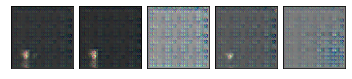

--- EPOCH 802/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]
Discriminator loss: 0.0521802619099617
Generator loss:     12.077448654174805
Saved checkpoint.
--- EPOCH 803/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: 0.3471577733755112
Generator loss:     13.466559028625488
Saved checkpoint.
--- EPOCH 804/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.07it/s]
Discriminator loss: -0.05906054377555847
Generator loss:     14.566222763061523
Saved checkpoint.
--- EPOCH 805/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.10it/s]
Discriminator loss: 0.20237328112125397
Generator loss:     13.111762046813965
Saved checkpoint.
--- EPOCH 806/2000 ---
100%|█████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: 0.46990635693073274
Generator loss:     9.51029634475708
Saved checkpoint.
--- EPOCH 837/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: -0.007806944847106934
Generator loss:     8.09448537826538
Saved checkpoint.
--- EPOCH 838/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]
Discriminator loss: 0.11403536051511765
Generator loss:     5.912340354919434
Saved checkpoint.
--- EPOCH 839/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]
Discriminator loss: 0.29994809329509736
Generator loss:     6.201187229156494
Saved checkpoint.
--- EPOCH 840/2000 ---
100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.09it/s]
Discriminator loss: 0.0555289626121521
Generator loss:     7.726938247680664
Saved checkpoint.
--- EPOCH 871/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]
Discriminator loss: 0.15565111190080644
Generator loss:     7.917402935028076
Saved checkpoint.
--- EPOCH 872/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]
Discriminator loss: -0.22625599205493926
Generator loss:     9.375596523284912
Saved checkpoint.
--- EPOCH 873/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: 0.08809191435575485
Generator loss:     11.25327091217041
Saved checkpoint.
--- EPOCH 874/2000 ---
100%|███████████████████████████████████████

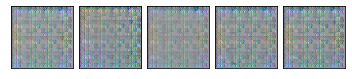

--- EPOCH 902/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]
Discriminator loss: -0.3335129752755165
Generator loss:     11.356215858459473
Saved checkpoint.
--- EPOCH 903/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]
Discriminator loss: -0.018660472333431245
Generator loss:     10.096938133239746
Saved checkpoint.
--- EPOCH 904/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]
Discriminator loss: 0.054616118967533114
Generator loss:     9.671253776550293
Saved checkpoint.
--- EPOCH 905/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: 0.04807930737733841
Generator loss:     10.073803520202636
Saved checkpoint.
--- EPOCH 906/2000 ---
100%|██████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.00it/s]
Discriminator loss: -0.05963180363178253
Generator loss:     7.177274513244629
Saved checkpoint.
--- EPOCH 937/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: -0.09846657961606979
Generator loss:     6.980119132995606
Saved checkpoint.
--- EPOCH 938/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]
Discriminator loss: 0.04043543189764023
Generator loss:     6.385594272613526
Saved checkpoint.
--- EPOCH 939/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]
Discriminator loss: 0.43906575441360474
Generator loss:     5.875623607635498
Saved checkpoint.
--- EPOCH 940/2000 ---
100%|█████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]
Discriminator loss: 0.1989580661058426
Generator loss:     8.4867094039917
Saved checkpoint.
--- EPOCH 971/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: -0.3143667809665203
Generator loss:     8.963931655883789
Saved checkpoint.
--- EPOCH 972/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: -0.005569569766521454
Generator loss:     9.070029258728027
Saved checkpoint.
--- EPOCH 973/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]
Discriminator loss: 0.19688767343759536
Generator loss:     9.171766471862792
Saved checkpoint.
--- EPOCH 974/2000 ---
100%|████████████████████████████████████████

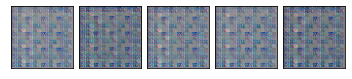

--- EPOCH 1002/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]
Discriminator loss: -0.05604528486728668
Generator loss:     8.340489101409911
Saved checkpoint.
--- EPOCH 1003/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: 0.19485477060079576
Generator loss:     7.040277099609375
Saved checkpoint.
--- EPOCH 1004/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]
Discriminator loss: -0.11518509984016419
Generator loss:     7.308233070373535
Saved checkpoint.
--- EPOCH 1005/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]
Discriminator loss: -0.17235042601823808
Generator loss:     7.626019668579102
Saved checkpoint.
--- EPOCH 1006/2000 ---
100%|████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]
Discriminator loss: 0.39844163358211515
Generator loss:     10.170982360839844
Saved checkpoint.
--- EPOCH 1037/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]
Discriminator loss: 0.20192452073097228
Generator loss:     8.494090843200684
Saved checkpoint.
--- EPOCH 1038/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]
Discriminator loss: 0.15722111463546753
Generator loss:     8.32810344696045
Saved checkpoint.
--- EPOCH 1039/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]
Discriminator loss: 0.01800185889005661
Generator loss:     8.751142883300782
Saved checkpoint.
--- EPOCH 1040/2000 ---
100%|███████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.84it/s]
Discriminator loss: 0.00390520840883255
Generator loss:     11.968659019470214
Saved checkpoint.
--- EPOCH 1071/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]
Discriminator loss: 0.15205204039812087
Generator loss:     13.066903114318848
Saved checkpoint.
--- EPOCH 1072/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]
Discriminator loss: 0.15463157296180724
Generator loss:     12.725650215148926
Saved checkpoint.
--- EPOCH 1073/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]
Discriminator loss: -0.22868727147579193
Generator loss:     13.3128231048584
Saved checkpoint.
--- EPOCH 1074/2000 ---
100%|████████████████████████████████

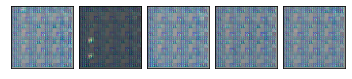

--- EPOCH 1102/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]
Discriminator loss: 0.07548513859510422
Generator loss:     15.555325508117676
Saved checkpoint.
--- EPOCH 1103/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]
Discriminator loss: -0.1859980046749115
Generator loss:     14.491461944580077
Saved checkpoint.
--- EPOCH 1104/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]
Discriminator loss: 0.14465589970350265
Generator loss:     14.934650230407716
Saved checkpoint.
--- EPOCH 1105/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]
Discriminator loss: -0.13395210206508637
Generator loss:     15.272920989990235
Saved checkpoint.
--- EPOCH 1106/2000 ---
100%|██████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]
Discriminator loss: -0.09814717769622802
Generator loss:     22.21367950439453
Saved checkpoint.
--- EPOCH 1137/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]
Discriminator loss: 0.4527457356452942
Generator loss:     22.89788360595703
Saved checkpoint.
--- EPOCH 1138/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]
Discriminator loss: -0.4571589738130569
Generator loss:     19.673459243774413
Saved checkpoint.
--- EPOCH 1139/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]
Discriminator loss: -0.3038911521434784
Generator loss:     20.202783203125
Saved checkpoint.
--- EPOCH 1140/2000 ---
100%|████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]
Discriminator loss: 0.14261856079101562
Generator loss:     18.08736209869385
Saved checkpoint.
--- EPOCH 1171/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]
Discriminator loss: -0.1910463750362396
Generator loss:     17.110917854309083
Saved checkpoint.
--- EPOCH 1172/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]
Discriminator loss: -0.3668453484773636
Generator loss:     17.26730136871338
Saved checkpoint.
--- EPOCH 1173/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.82it/s]
Discriminator loss: -0.07638666033744812
Generator loss:     17.292434310913087
Saved checkpoint.
--- EPOCH 1174/2000 ---
100%|████████████████████████████████

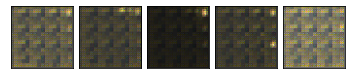

--- EPOCH 1202/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]
Discriminator loss: -0.4737358033657074
Generator loss:     24.1599552154541
Saved checkpoint.
--- EPOCH 1203/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]
Discriminator loss: 0.023777338862419128
Generator loss:     25.404241180419923
Saved checkpoint.
--- EPOCH 1204/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.75it/s]
Discriminator loss: -0.04967021644115448
Generator loss:     22.297275924682616
Saved checkpoint.
--- EPOCH 1205/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]
Discriminator loss: -0.1542498618364334
Generator loss:     23.173133087158202
Saved checkpoint.
--- EPOCH 1206/2000 ---
100%|███████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]
Discriminator loss: 0.0924688994884491
Generator loss:     19.41105422973633
Saved checkpoint.
--- EPOCH 1237/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]
Discriminator loss: -0.008499441295862198
Generator loss:     16.103733825683594
Saved checkpoint.
--- EPOCH 1238/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: -0.07771427631378174
Generator loss:     16.89663600921631
Saved checkpoint.
--- EPOCH 1239/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]
Discriminator loss: -0.31063013076782225
Generator loss:     16.47733955383301
Saved checkpoint.
--- EPOCH 1240/2000 ---
100%|███████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]
Discriminator loss: -0.09525520801544189
Generator loss:     15.689510345458984
Saved checkpoint.
--- EPOCH 1271/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: -0.42130869925022124
Generator loss:     15.902166175842286
Saved checkpoint.
--- EPOCH 1272/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: 0.30482486486434934
Generator loss:     20.186412811279297
Saved checkpoint.
--- EPOCH 1273/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]
Discriminator loss: -0.16168069690465928
Generator loss:     16.91892852783203
Saved checkpoint.
--- EPOCH 1274/2000 ---
100%|█████████████████████████████

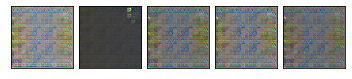

--- EPOCH 1302/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: -0.06436504423618317
Generator loss:     16.116171455383302
Saved checkpoint.
--- EPOCH 1303/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]
Discriminator loss: 0.0926208183169365
Generator loss:     15.654520034790039
Saved checkpoint.
--- EPOCH 1304/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]
Discriminator loss: 0.3356748893857002
Generator loss:     14.679350280761719
Saved checkpoint.
--- EPOCH 1305/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]
Discriminator loss: -0.03271162211894989
Generator loss:     13.738766479492188
Saved checkpoint.
--- EPOCH 1306/2000 ---
100%|███████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]
Discriminator loss: -0.20143316984176635
Generator loss:     10.380398178100586
Saved checkpoint.
--- EPOCH 1337/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]
Discriminator loss: 0.30899099707603456
Generator loss:     11.385543251037598
Saved checkpoint.
--- EPOCH 1338/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]
Discriminator loss: 0.0764506846666336
Generator loss:     13.037354278564454
Saved checkpoint.
--- EPOCH 1339/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]
Discriminator loss: -0.4757303297519684
Generator loss:     11.615326690673829
Saved checkpoint.
--- EPOCH 1340/2000 ---
100%|███████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: -0.28266811445355416
Generator loss:     11.737053108215331
Saved checkpoint.
--- EPOCH 1371/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]
Discriminator loss: 0.46335929036140444
Generator loss:     12.511926460266114
Saved checkpoint.
--- EPOCH 1372/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]
Discriminator loss: -0.34775072485208514
Generator loss:     12.560857772827148
Saved checkpoint.
--- EPOCH 1373/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]
Discriminator loss: -0.08595939427614212
Generator loss:     13.63139591217041
Saved checkpoint.
--- EPOCH 1374/2000 ---
100%|█████████████████████████████

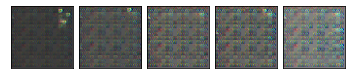

--- EPOCH 1402/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]
Discriminator loss: 0.045693013817071915
Generator loss:     11.266921424865723
Saved checkpoint.
--- EPOCH 1403/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]
Discriminator loss: 0.11068973243236542
Generator loss:     9.396293258666992
Saved checkpoint.
--- EPOCH 1404/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]
Discriminator loss: -0.0365043081343174
Generator loss:     9.480079078674317
Saved checkpoint.
--- EPOCH 1405/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]
Discriminator loss: 0.26129363030195235
Generator loss:     9.54395408630371
Saved checkpoint.
--- EPOCH 1406/2000 ---
100%|██████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: -0.42987905740737914
Generator loss:     16.273992156982423
Saved checkpoint.
--- EPOCH 1437/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]
Discriminator loss: -0.1100662738084793
Generator loss:     15.654309463500976
Saved checkpoint.
--- EPOCH 1438/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]
Discriminator loss: 0.2641773223876953
Generator loss:     18.52927436828613
Saved checkpoint.
--- EPOCH 1439/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]
Discriminator loss: -0.009976696968078614
Generator loss:     15.375658798217774
Saved checkpoint.
--- EPOCH 1440/2000 ---
100%|██████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]
Discriminator loss: 0.036408227682113645
Generator loss:     11.860898971557617
Saved checkpoint.
--- EPOCH 1471/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]
Discriminator loss: -0.1913163974881172
Generator loss:     16.72041549682617
Saved checkpoint.
--- EPOCH 1472/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]
Discriminator loss: 0.31333805322647096
Generator loss:     17.041846656799315
Saved checkpoint.
--- EPOCH 1473/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]
Discriminator loss: 0.0013497531414031982
Generator loss:     11.58576488494873
Saved checkpoint.
--- EPOCH 1474/2000 ---
100%|██████████████████████████████

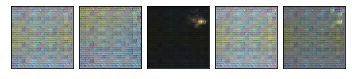

--- EPOCH 1502/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]
Discriminator loss: -0.07907753884792328
Generator loss:     12.986827659606934
Saved checkpoint.
--- EPOCH 1503/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.86it/s]
Discriminator loss: 0.277743436396122
Generator loss:     12.68162498474121
Saved checkpoint.
--- EPOCH 1504/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]
Discriminator loss: -0.29599432945251464
Generator loss:     16.58329963684082
Saved checkpoint.
--- EPOCH 1505/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]
Discriminator loss: -0.07101413607597351
Generator loss:     12.510616111755372
Saved checkpoint.
--- EPOCH 1506/2000 ---
100%|████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.86it/s]
Discriminator loss: 0.19946565926074983
Generator loss:     18.367299842834473
Saved checkpoint.
--- EPOCH 1537/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]
Discriminator loss: 0.32753726840019226
Generator loss:     14.049105262756347
Saved checkpoint.
--- EPOCH 1538/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]
Discriminator loss: -0.05178119540214539
Generator loss:     13.30444278717041
Saved checkpoint.
--- EPOCH 1539/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: -0.06773453652858734
Generator loss:     13.423593902587891
Saved checkpoint.
--- EPOCH 1540/2000 ---
100%|██████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]
Discriminator loss: 0.23806696832180024
Generator loss:     16.477063369750976
Saved checkpoint.
--- EPOCH 1571/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: 0.7211712002754211
Generator loss:     16.607707977294922
Saved checkpoint.
--- EPOCH 1572/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]
Discriminator loss: 0.4910394199192524
Generator loss:     15.683740615844727
Saved checkpoint.
--- EPOCH 1573/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]
Discriminator loss: 0.3538751006126404
Generator loss:     14.687614059448242
Saved checkpoint.
--- EPOCH 1574/2000 ---
100%|██████████████████████████████████

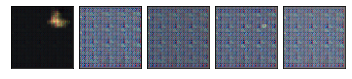

--- EPOCH 1602/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]
Discriminator loss: -0.23488616049289704
Generator loss:     14.980364227294922
Saved checkpoint.
--- EPOCH 1603/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]
Discriminator loss: -0.07441741824150086
Generator loss:     14.407164573669434
Saved checkpoint.
--- EPOCH 1604/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]
Discriminator loss: 0.24827820360660552
Generator loss:     15.829235458374024
Saved checkpoint.
--- EPOCH 1605/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]
Discriminator loss: -0.27733008563518524
Generator loss:     14.54161434173584
Saved checkpoint.
--- EPOCH 1606/2000 ---
100%|█████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]
Discriminator loss: -0.6666063755750656
Generator loss:     25.936058044433594
Saved checkpoint.
--- EPOCH 1637/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]
Discriminator loss: 0.25186591148376464
Generator loss:     30.298360443115236
Saved checkpoint.
--- EPOCH 1638/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]
Discriminator loss: 0.4614602759480476
Generator loss:     24.693099975585938
Saved checkpoint.
--- EPOCH 1639/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: -0.3372413247823715
Generator loss:     23.214326858520508
Saved checkpoint.
--- EPOCH 1640/2000 ---
100%|████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]
Discriminator loss: 0.36972273588180543
Generator loss:     21.984617233276367
Saved checkpoint.
--- EPOCH 1671/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: -0.4486388862133026
Generator loss:     21.470919799804687
Saved checkpoint.
--- EPOCH 1672/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]
Discriminator loss: 1.0124764621257782
Generator loss:     19.875585556030273
Saved checkpoint.
--- EPOCH 1673/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]
Discriminator loss: -0.015004363656044007
Generator loss:     19.15594596862793
Saved checkpoint.
--- EPOCH 1674/2000 ---
100%|███████████████████████████████

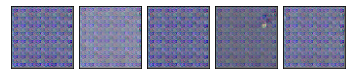

--- EPOCH 1702/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]
Discriminator loss: 0.36877747178077697
Generator loss:     22.376794815063477
Saved checkpoint.
--- EPOCH 1703/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.84it/s]
Discriminator loss: 0.2130251944065094
Generator loss:     18.07529220581055
Saved checkpoint.
--- EPOCH 1704/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]
Discriminator loss: 0.20625227093696594
Generator loss:     17.24560432434082
Saved checkpoint.
--- EPOCH 1705/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]
Discriminator loss: -0.5881636261940002
Generator loss:     15.56044979095459
Saved checkpoint.
--- EPOCH 1706/2000 ---
100%|███████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.82it/s]
Discriminator loss: -0.2394550085067749
Generator loss:     14.336444664001466
Saved checkpoint.
--- EPOCH 1737/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]
Discriminator loss: -0.03590348064899444
Generator loss:     14.669163131713868
Saved checkpoint.
--- EPOCH 1738/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]
Discriminator loss: 0.4854852557182312
Generator loss:     16.287661170959474
Saved checkpoint.
--- EPOCH 1739/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]
Discriminator loss: -0.445103845000267
Generator loss:     15.817253875732423
Saved checkpoint.
--- EPOCH 1740/2000 ---
100%|████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]
Discriminator loss: 0.41657965183258056
Generator loss:     14.226105308532714
Saved checkpoint.
--- EPOCH 1771/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]
Discriminator loss: -0.5308969259262085
Generator loss:     13.635981941223145
Saved checkpoint.
--- EPOCH 1772/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]
Discriminator loss: -0.6475665211677551
Generator loss:     14.444400596618653
Saved checkpoint.
--- EPOCH 1773/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.82it/s]
Discriminator loss: -0.1847791165113449
Generator loss:     18.112758255004884
Saved checkpoint.
--- EPOCH 1774/2000 ---
100%|███████████████████████████████

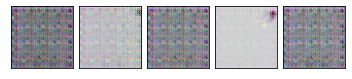

--- EPOCH 1802/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]
Discriminator loss: -0.41423702239990234
Generator loss:     19.08479995727539
Saved checkpoint.
--- EPOCH 1803/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]
Discriminator loss: -0.6783859550952911
Generator loss:     16.17197952270508
Saved checkpoint.
--- EPOCH 1804/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]
Discriminator loss: 0.22143919467926027
Generator loss:     16.3795654296875
Saved checkpoint.
--- EPOCH 1805/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: 0.12710047662258148
Generator loss:     15.692778968811036
Saved checkpoint.
--- EPOCH 1806/2000 ---
100%|██████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]
Discriminator loss: -0.35884259045124056
Generator loss:     22.615708923339845
Saved checkpoint.
--- EPOCH 1837/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]
Discriminator loss: -0.5137225449085235
Generator loss:     22.654562759399415
Saved checkpoint.
--- EPOCH 1838/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]
Discriminator loss: -0.5403113186359405
Generator loss:     21.792339706420897
Saved checkpoint.
--- EPOCH 1839/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]
Discriminator loss: 0.6534560441970825
Generator loss:     20.76071968078613
Saved checkpoint.
--- EPOCH 1840/2000 ---
100%|████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]
Discriminator loss: -0.576034551858902
Generator loss:     18.17003631591797
Saved checkpoint.
--- EPOCH 1871/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]
Discriminator loss: -0.4602133572101593
Generator loss:     20.815807342529297
Saved checkpoint.
--- EPOCH 1872/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]
Discriminator loss: -0.0752510666847229
Generator loss:     18.935488891601562
Saved checkpoint.
--- EPOCH 1873/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]
Discriminator loss: 0.30705298483371735
Generator loss:     18.530509567260744
Saved checkpoint.
--- EPOCH 1874/2000 ---
100%|█████████████████████████████████

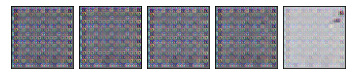

--- EPOCH 1902/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]
Discriminator loss: 0.88014897108078
Generator loss:     18.36997261047363
Saved checkpoint.
--- EPOCH 1903/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]
Discriminator loss: -0.16001570522785186
Generator loss:     18.20948715209961
Saved checkpoint.
--- EPOCH 1904/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]
Discriminator loss: 0.41415980756282805
Generator loss:     16.854458618164063
Saved checkpoint.
--- EPOCH 1905/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]
Discriminator loss: 0.058953702449798584
Generator loss:     16.356047248840333
Saved checkpoint.
--- EPOCH 1906/2000 ---
100%|██████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]
Discriminator loss: 0.24610810428857804
Generator loss:     19.11555290222168
Saved checkpoint.
--- EPOCH 1937/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]
Discriminator loss: -1.0096070021390915
Generator loss:     17.891067123413087
Saved checkpoint.
--- EPOCH 1938/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.75it/s]
Discriminator loss: 0.023459488153457643
Generator loss:     19.52297019958496
Saved checkpoint.
--- EPOCH 1939/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.00it/s]
Discriminator loss: 0.5372321277856826
Generator loss:     18.933631896972656
Saved checkpoint.
--- EPOCH 1940/2000 ---
100%|█████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.00it/s]
Discriminator loss: -0.21035897731781006
Generator loss:     23.937311935424805
Saved checkpoint.
--- EPOCH 1971/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]
Discriminator loss: 0.507556465268135
Generator loss:     19.275513458251954
Saved checkpoint.
--- EPOCH 1972/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.07it/s]
Discriminator loss: 0.23576756864786147
Generator loss:     21.012554550170897
Saved checkpoint.
--- EPOCH 1973/2000 ---
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]
Discriminator loss: 0.44067108929157256
Generator loss:     18.830741119384765
Saved checkpoint.
--- EPOCH 1974/2000 ---
100%|████████████████████████████████

In [55]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 2000

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            
        if epoch_idx % 100 == 0:
            samples = gen.sample(5, with_grad=False)
            fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
            IPython.display.display(fig)
            plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

In [56]:
5 % 100

5

*** Images Generated from best model:


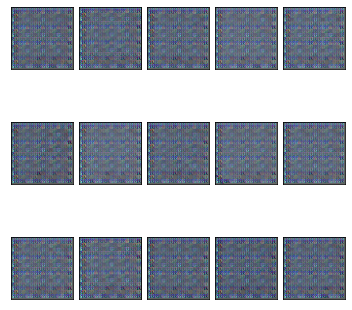

In [57]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [58]:
from cs3600.answers import display_answer
import hw4.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [59]:
display_answer(hw4.answers.part3_q1)


**Your answer:**



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [60]:
display_answer(hw4.answers.part3_q2)


**Your answer:**



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [61]:
display_answer(hw4.answers.part3_q3)


**Your answer:**

